In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

import torch
from torch.nn import CrossEntropyLoss, NLLLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from os.path import exists

from util import test_loss, train_NN

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

input_shape = (batch_size, 3, 32, 32)
num_labels = 10

Files already downloaded and verified
Files already downloaded and verified


In [4]:
from Models import VGGNet

VGGNN = VGGNet(input_shape, num_labels, device)

summary(VGGNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 32, 32]         896
│    └─ReLU: 2-2                         [100, 32, 32, 32]         --
│    └─Conv2d: 2-3                       [100, 32, 32, 32]         9,248
│    └─ReLU: 2-4                         [100, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [100, 32, 16, 16]         --
│    └─Conv2d: 2-6                       [100, 64, 16, 16]         18,496
│    └─ReLU: 2-7                         [100, 64, 16, 16]         --
│    └─Conv2d: 2-8                       [100, 64, 16, 16]         36,928
│    └─ReLU: 2-9                         [100, 64, 16, 16]         --
│    └─MaxPool2d: 2-10                   [100, 64, 8, 8]           --
│    └─Conv2d: 2-11                      [100, 128, 8, 8]          73,856

In [5]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(VGGNN.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [6]:
stats = train_NN(VGGNN, train_dataloader,
        test_dataloader, epochs=20, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 2.303
test_loss: 2.302, test_accuracy: 10.0
[1,   400] train_loss: 2.296
test_loss: 2.233, test_accuracy: 19.89
[2,   200] train_loss: 1.866
test_loss: 1.723, test_accuracy: 35.62
[2,   400] train_loss: 1.676
test_loss: 1.582, test_accuracy: 40.28
[3,   200] train_loss: 1.483
test_loss: 1.431, test_accuracy: 47.31
[3,   400] train_loss: 1.369
test_loss: 1.350, test_accuracy: 50.27
[4,   200] train_loss: 1.207
test_loss: 1.214, test_accuracy: 56.24
[4,   400] train_loss: 1.126
test_loss: 1.089, test_accuracy: 60.68
[5,   200] train_loss: 1.003
test_loss: 1.031, test_accuracy: 63.48
[5,   400] train_loss: 0.972
test_loss: 0.980, test_accuracy: 65.5
[6,   200] train_loss: 0.875
test_loss: 0.905, test_accuracy: 68.56
[6,   400] train_loss: 0.861
test_loss: 0.929, test_accuracy: 67.78
[7,   200] train_loss: 0.778
test_loss: 0.864, test_accuracy: 70.41
[7,   400] train_loss: 0.751
test_loss: 0.820, test_accuracy: 71.95
[8,   200] train_loss: 0.674
test_loss: 0.830, tes

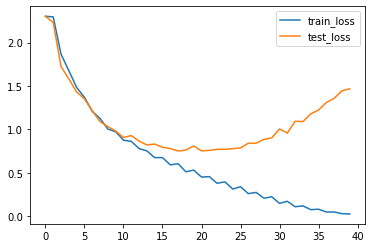

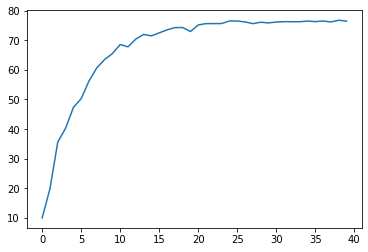

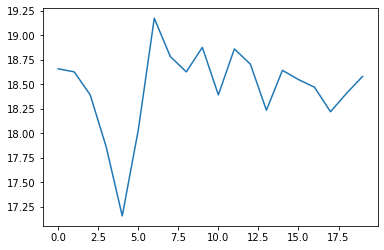

In [7]:
plt.plot(stats[0], label="train_loss")
#plt.show()
plt.plot(stats[1], label="test_loss")
plt.legend()
plt.show()
plt.plot(stats[2])
plt.show()
plt.plot(stats[3])
plt.show()

In [9]:
torch.save(VGGNN.state_dict(), "./models/Cifar/VGGNN_1.pth")

In [11]:
train_error_json = json.dumps(stats[0])
test_error_json = json.dumps(stats[1])
accuracy_json = json.dumps(stats[2])
times_json = json.dumps(stats[3])

stats_dict = {"train_error": train_error_json, "test_error": test_error_json, "accuracy": accuracy_json, "time": times_json}

In [ ]:
with open('./models/Cifar/VGGNN_1.json', 'w', encoding='utf-8') as f:
    json.dump(stats_dict, f, ensure_ascii=False, indent=4)

In [4]:
from Models import VGGNet2

VGGNN2 = VGGNet2(input_shape, num_labels, device)

summary(VGGNN2, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet2                                  [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 32, 32]         896
│    └─ReLU: 2-2                         [100, 32, 32, 32]         --
│    └─Conv2d: 2-3                       [100, 32, 32, 32]         9,248
│    └─ReLU: 2-4                         [100, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [100, 32, 16, 16]         --
│    └─Dropout2d: 2-6                    [100, 32, 16, 16]         --
│    └─Conv2d: 2-7                       [100, 64, 16, 16]         18,496
│    └─ReLU: 2-8                         [100, 64, 16, 16]         --
│    └─Conv2d: 2-9                       [100, 64, 16, 16]         36,928
│    └─ReLU: 2-10                        [100, 64, 16, 16]         --
│    └─MaxPool2d: 2-11                   [100, 64, 8, 8]           --
│  

In [5]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(VGGNN2.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [6]:
stats = train_NN(VGGNN2, train_dataloader,
        test_dataloader, epochs=20, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 2.303
test_loss: 2.302, test_accuracy: 10.06
[1,   400] train_loss: 2.302
test_loss: 2.298, test_accuracy: 12.94
[2,   200] train_loss: 2.054
test_loss: 1.972, test_accuracy: 28.01
[2,   400] train_loss: 1.870
test_loss: 1.762, test_accuracy: 35.34
[3,   200] train_loss: 1.664
test_loss: 1.643, test_accuracy: 40.07
[3,   400] train_loss: 1.573
test_loss: 1.575, test_accuracy: 42.4
[4,   200] train_loss: 1.458
test_loss: 1.438, test_accuracy: 46.77
[4,   400] train_loss: 1.400
test_loss: 1.367, test_accuracy: 50.39
[5,   200] train_loss: 1.301
test_loss: 1.336, test_accuracy: 51.99
[5,   400] train_loss: 1.246
test_loss: 1.263, test_accuracy: 55.01
[6,   200] train_loss: 1.192
test_loss: 1.196, test_accuracy: 57.76
[6,   400] train_loss: 1.148
test_loss: 1.182, test_accuracy: 57.38
[7,   200] train_loss: 1.096
test_loss: 1.136, test_accuracy: 59.67
[7,   400] train_loss: 1.087
test_loss: 1.123, test_accuracy: 59.74
[8,   200] train_loss: 1.034
test_loss: 1.082, te

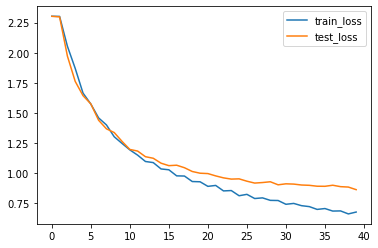

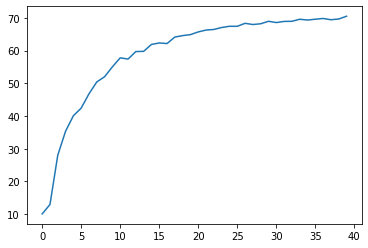

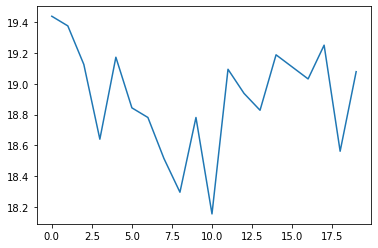

In [7]:
plt.plot(stats[0], label="train_loss")
#plt.show()
plt.plot(stats[1], label="test_loss")
plt.legend()
plt.show()
plt.plot(stats[2])
plt.show()
plt.plot(stats[3])
plt.show()

In [ ]:
torch.save(VGGNN2.state_dict(), "./models/Cifar/VGGNN_2.pth")

In [ ]:
train_error_json = json.dumps(stats[0])
test_error_json = json.dumps(stats[1])
accuracy_json = json.dumps(stats[2])
times_json = json.dumps(stats[3])

stats_dict = {"train_error": train_error_json, "test_error": test_error_json, "accuracy": accuracy_json, "time": times_json}

In [ ]:
with open('./models/Cifar/VGGNN_2.json', 'w', encoding='utf-8') as f:
    json.dump(stats_dict, f, ensure_ascii=False, indent=4)

In [4]:
from Models import Cifar10_Conv_Net

Cifar10_Conv_NN = Cifar10_Conv_Net(input_shape, num_labels, device=device)

summary(Cifar10_Conv_NN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
Cifar10_Conv_Net                         [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─Conv2d: 2-5                       [100, 16, 16, 16]         2,416
│    └─BatchNorm2d: 2-6                  [100, 16, 16, 16]         32
│    └─Tanh: 2-7                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-8                    [100, 16, 8, 8]           --
│    └─Conv2d: 2-9                       [100, 32, 8, 8]           4,640
│    └─BatchNorm2d: 2-10                 [100, 32, 8, 8]           64
│    └─Tanh: 2-11                        [100, 32, 8, 8]           --
│    └─F

In [6]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(Cifar10_Conv_NN.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [11]:
leDepthStats = train_NN(Cifar10_Conv_NN, train_dataloader,
        test_dataloader, epochs=4, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 0.777
test_loss: 1.125, test_accuracy: 61.79
[1,   400] train_loss: 0.782
test_loss: 1.126, test_accuracy: 61.79
[2,   200] train_loss: 0.775
test_loss: 1.126, test_accuracy: 61.85
[2,   400] train_loss: 0.777
test_loss: 1.127, test_accuracy: 61.96
[3,   200] train_loss: 0.772
test_loss: 1.127, test_accuracy: 61.85
[3,   400] train_loss: 0.778
test_loss: 1.127, test_accuracy: 61.9
[4,   200] train_loss: 0.768
test_loss: 1.127, test_accuracy: 61.91
[4,   400] train_loss: 0.771
test_loss: 1.127, test_accuracy: 61.83


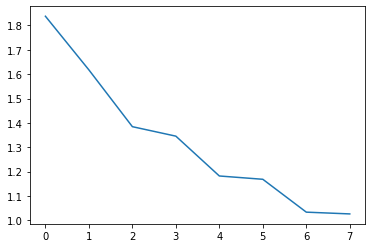

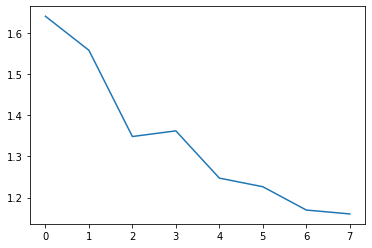

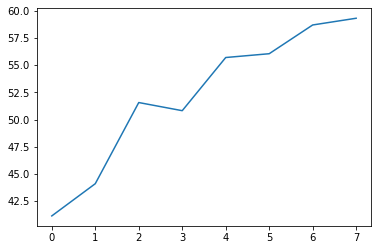

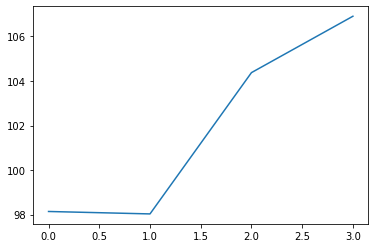

In [9]:
plt.plot(leDepthStats[0])
plt.show()
plt.plot(leDepthStats[1])
plt.show()
plt.plot(leDepthStats[2])
plt.show()
plt.plot(leDepthStats[3])
plt.show()

In [8]:
torch.save(Cifar10_Conv_NN.state_dict(), "./models/Cifar/Cifar10_Conv_NN.pth")

In [20]:
from Models import Cifar10_ASL_Net

expansion_rate = 3

Cifar10_ASL_NN = Cifar10_ASL_Net(input_shape, num_labels, expansion_rate, device)

summary(Cifar10_ASL_NN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
Cifar10_ASL_Net                          [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─CSC_block: 2-5                    [100, 16, 16, 16]         --
│    │    └─Sequential: 3-1              --                        502
│    └─Tanh: 2-6                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-7                    [100, 16, 8, 8]           --
│    └─CSC_block: 2-8                    [100, 32, 8, 8]           --
│    │    └─Sequential: 3-2              --                        2,576
│    └─Tanh: 2-9                         [100, 32, 8, 8]           --
│    └─Fla

In [21]:
criterion = CrossEntropyLoss()
Cifar10_ASL_NN_optimizer = optim.SGD(Cifar10_ASL_NN.parameters(), lr=0.1, momentum=0.9)
scheduler_Cifar = optim.lr_scheduler.ExponentialLR(Cifar10_ASL_NN_optimizer, gamma=0.8)

In [23]:
leASLStats = train_NN(Cifar10_ASL_NN, train_dataloader,
        test_dataloader, epochs=6, optimizer=Cifar10_ASL_NN_optimizer, criterion=criterion,
        scheduler=scheduler_Cifar, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 0.707
test_loss: 1.035, test_accuracy: 64.55
[1,   400] train_loss: 0.715
test_loss: 1.038, test_accuracy: 64.73
[2,   200] train_loss: 0.687
test_loss: 1.037, test_accuracy: 65.08
[2,   400] train_loss: 0.683
test_loss: 1.037, test_accuracy: 65.0
[3,   200] train_loss: 0.681
test_loss: 1.037, test_accuracy: 65.11
[3,   400] train_loss: 0.666
test_loss: 1.038, test_accuracy: 65.04
[4,   200] train_loss: 0.672
test_loss: 1.038, test_accuracy: 65.02


KeyboardInterrupt: 

In [ ]:
torch.save(Cifar10_ASL_Net.state_dict(), "./models/Cifar/Cifar10_ALS_NN.pth")

In [6]:
PATH = "models/Cifar/Cifar10.pth"

if exists(PATH):
    NN_cif.load_state_dict(torch.load(PATH))
    NN_cif.eval()

In [9]:
%%timeit
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer_Cifar.zero_grad()

        # forward + backward + optimize
        outputs = NN_cif(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_Cifar.step()

        # print statistics
        running_loss += loss.item()
        if i % 250 == 249:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] train_loss: {running_loss / 100:.3f}')
            running_loss = 0.0
            print(test_loss(NN_cif, test_dataloader, criterion, device))

    scheduler_Cifar.step()

[1,   244] train_loss: 4.071
(1.4727221763134002, 47.23)


In [10]:
torch.save(NN_cif.state_dict(), "./models/Cifar/Cifar10.pth")

In [8]:
from Models import Cifar10_Net

criterion = CrossEntropyLoss()


input_shape = (100, 3, 32, 32)
num_labels = 10
expansion_rate = 3

NN2_cif = Cifar10_Net(input_shape, num_labels, expansion_rate)


PATH = "models/Cifar/Cifar10.pth"

if exists(PATH):
    NN2_cif.load_state_dict(torch.load(PATH))
    NN2_cif.eval()

print(test_loss(NN2_cif, test_dataloader, criterion))

(1.413678903579712, 49.93)
